In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("./Data"))

# Any results you write to the current directory are saved as output.

['result.csv', 'sample_submission.csv', 'test', 'test.zip', 'test_s', 'train', 'train.csv', 'train.zip', 'train_s']


In [2]:
import csv
import random
import tensorflow as tf
import keras
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib.pyplot import imshow
%matplotlib inline

Using TensorFlow backend.


In [3]:
def mat_to_dict(ids, f_mat):
    """
    Convert id list and feature matrix into dictionary.
    """
    res = dict()
    for id_, f in zip(ids, f_mat):
        res[id_] = f
    
    return res

In [4]:
def get_name_set(filelist):
    """
    Fetch common name from file names in file name list.
    Common name does not contain color.
    
    filelist, list of file names.
    
    Return a set of common name.
    """
    color = ["green", "blue", "red", "yellow"]
    name_set = set()
    for filename in filelist:
        name = filename.split("_")[0]
        name_set.add(name)
    
    return name_set

In [5]:
def get_image_tensor(idx, fname_lst):
    """
    Get image tensor with index "idx" from file name list "fname_lst".
    idx, index of image
    fname_lst, list of file names
    """
    fname = file_name_green[idx]
    full_name = os.path.join(folder, fname)

    image_data = tf.gfile.FastGFile(full_name, 'rb').read()
    image_tensor = tf.image.decode_png(image_data, channels=3)
    
    return image_tensor

In [6]:
def get_image_tensors(fname_lst):
    """
    Get full dimension image tensor in given filename list.
    fname_lst, list of file names.
    
    Return image tensors.
    """
    image_tensors = tf.convert_to_tensor([get_image_tensor(idx) 
                                          for idx in range(len(fname_lst))], tf.float32)
    print("image arr shape: ", image_tensors.get_shape())
    
    return image_tensors

In [7]:
def get_image_arr(fname_lst, folder):
    """
    Get full dimension image array in given filename list.
    fname_lst, list of file names.
    
    Return image array.
    """
    img_arr = []
    for fname in fname_lst:
        im = Image.open(os.path.join(folder,fname), 'r')
        img_arr.append(np.array(im.convert('RGB')))
        
    return np.array(img_arr)

In [8]:
def pick_labels(f_dict, fname_lst):
    """
    Pick labels from f_dict. 
    The picked feature matrix corresponding to file in fname_lst.
    
    f_dict, diction with fname as key and label vector as value.
    fname_lst, list of file names.
    
    Return label vectors.
    """
    res = []
    for fname in fname_lst:
        res.append(f_dict[fname])
    
#     print("{} feature vector picked: ".format(len(res)))
    
    return np.array(res)

In [9]:
def fetch_batch_X(f_dict, scale, idx, folder):
    pick_list = list(f_dict.keys())
    
    fname_batch_ = pick_list[idx*scale: (idx+1)*scale]
    fname_green_batch_ = [item + "_green.png" for item in fname_batch_]
    
    image_arr = get_image_arr(fname_green_batch_, folder)
    image_arr = image_arr / 256.
    
    return image_arr

In [10]:
def fetch_batch_Y(f_dict, scale, idx, folder):
    pick_list = list(f_dict.keys())
    
    fname_batch_ = pick_list[idx*scale: (idx+1)*scale]
    fname_green_batch_ = [item + "_green.png" for item in fname_batch_]
    
    labels_batch_ = pick_labels(f_dict, fname_batch_)
    labels = labels_batch_
    labels = labels.reshape((-1,1,1,28))
    
    return labels

In [11]:
def fetch_batch_data(f_dict, scale, idx, folder):
    """
    f_dict, filename dictionary
    scale, batch size
    idx, batch number
    
    """
    X = fetch_batch_X(f_dict, scale, idx, folder)
    Y = fetch_batch_Y(f_dict, scale, idx, folder)
    
    return X, Y

In [12]:
def batch_norm(tensor, scale, beta, epsilon):
    """
    Batch Normalization.
    tensor, n dimensions tensor
    scale, n-1 dimensions tensor
    beta, n-1 dimensions tensor
    epsilon, small number to avoid dividing by zero
    """
    batch_mean, batch_var = tf.nn.moments(tensor, [0])
    
    return tf.nn.batch_normalization(x=tensor, mean=batch_mean, variance=batch_var, scale=scale, offset=beta, variance_epsilon=epsilon)
    

In [13]:
def rand_sample(f_dict, scale):
    """
    Randomly select samples from dict, filename as key, image data as values.
    Scale is sample numbers you want.
    """
    subset = dict()
    keys = random.sample(f_dict.keys(), scale)
    for item in keys:
        subset[item] = f_dict[item]
    
    return subset

In [14]:
def get_weights(labels, delta=1, threshold=0.2):
    """
    Calculate weights for positive samples and negative samples.
    labels, label vectors
    delta, small number to avoid divided by zero
    threshold, maximum weight threshold
    
    Return weight for positive, negative; count for positive, negative.
    """
    samples = np.squeeze(labels)
    
    (N, N_c) = samples.shape # sample scale, classes
    
    N_p = np.sum(samples, axis=0)
    
    N_n = N - N_p
    
    W_p = 1 / (N_p + delta)
    
    W_p = np.array([item if item < threshold else threshold for item in W_p])
    
    W_n = 1 / (N_n + delta)
    
    W_n = np.array([item if item < threshold else threshold for item in W_n])
    
    return W_p.reshape(1,-1), W_n.reshape(1,-1), N_p, N_n

In [15]:
def showWeights(W_p, W_n, N_p, N_n):
    """
    Show weighted weights W_p, W_n and Count N_p, N_n.
    """
    print([round(item, 2) for item in W_p[0]])
    print([round(item, 2) for item in W_n[0]])
    print([int(item) for item in N_p])
    print([int(item) for item in N_n])

In [16]:
# def func():
#     x = np.linspace y = np.sqrt(1/2)**(1/x)
#     plt.plot(x, y)

In [17]:
def inference(inputs, filter1, filter2, scale1, beta1, scale2, beta2, epsilon):
    """
    Forward calculation.
    
    inputs, input tensor
    filter1,
    filter2,
    scale1,
    beta1,
    scale2,
    beta2,
    epsilon,
    
    Return logits vectors.
    """

    conv1 = tf.nn.conv2d(inputs, filter1, strides=[1, 8, 8, 1], padding="VALID")
    pool1 = tf.nn.max_pool(conv1, ksize=[1,3,3,1], strides=[1,2,2,1], padding='VALID')
    
    norm1 = batch_norm(pool1, scale1, beta1, epsilon)
    
#     norm1 = tf.nn.batch_normalization(pool1, depth_radius=5, bias=1, alpha=1, beta=0.5)
    
    conv2 = tf.nn.conv2d(norm1, filter2, strides=[1, 2, 2, 1], padding="VALID")
    pool2 = tf.nn.max_pool(conv2, ksize=[1, 6, 6, 1], strides=[1,1,1,1], padding='VALID')
    
    norm2 = batch_norm(pool2, scale2, beta2, epsilon)
    
#     norm2 = tf.nn.batch_normalization(pool2, depth_radius=5, bias=1, alpha=1, beta=0.5)
    
    local3 = tf.layers.dense(norm2, units=600, activation=tf.nn.sigmoid, use_bias=True)
    
    local4 = tf.layers.dense(local3, units=28, activation=tf.nn.sigmoid, use_bias=True)
    
    return local4

In [18]:
def calculate_loss(predict, labels, weighted=False, Wp=None, Wn=None):
    """
    Calculate weighted loss.
    predict, predict vector.
    labels, label vector.
    weighted, flag for weighted loss
    Wp, positive weight vector.
    Wn, negative weight vector.
    Return weighted loss.
    """
    one = tf.constant(1., shape=[1, 28], dtype='float32')
    
    if weighted:
        p = tf.negative(tf.multiply(Wp, tf.multiply(labels, tf.log(predict))))
        n = tf.negative(tf.multiply(Wn, tf.multiply((one-labels), tf.log(one-predict))))
    else:
        p = tf.negative(tf.multiply(labels, tf.log(predict)))
        n = tf.negative(tf.multiply(tf.subtract(one, labels), 
                                    tf.log(tf.subtract(one, predict))))
    
    loss = tf.add(p, n)
    
    return loss

In [19]:
def calculate_rate(predict, label, p, l):
    """
    Count for four different types: 10, 01, 00, 11.
    """
    
    stat = np.array([ [1 if p_item == p and l_item == l else 0 
                       for p_item, l_item in zip(p_, l_)] 
                     for p_, l_ in zip(predict.T, label.T)])
    
    rate = np.sum(stat.T, axis=0)
    
    return rate

In [20]:
def evaluation(y_, y, debug=False):
    """
    Calculate tp, fp, tn, fn. 
    Calculate rr, pr, acc, f1-score.
    Return rr, pr, acc, f1-score.
    y_: predictions (logits)
    y: labels
    """
    scale = len(y) # sample scale
    y = np.squeeze(y)
    y = np.array(y, dtype='int')
    
    tn = calculate_rate(y_, y, p=0, l=0)
    tp = calculate_rate(y_, y, p=1, l=1)
    fn = calculate_rate(y_, y, p=0, l=1)
    fp = calculate_rate(y_, y, p=1, l=0)
    
    rr = [0 if (tp_item + fn_item) == 0 else tp_item / 
          (tp_item + fn_item)  for tp_item, fn_item in zip(tp, fn)]
    pr = [0 if (tp_item + fp_item) == 0 else tp_item / 
          (tp_item + fp_item)  for tp_item, fp_item in zip(tp, fp)]
    acc = (tp + tn) / scale
    
    f1 = [0 if (pr_item + rr_item == 0) else 
          (2*pr_item*rr_item)/(pr_item + rr_item) for pr_item, rr_item in zip(pr, rr)]
    
    rr_avg = np.average(rr)
    pr_avg = np.average(pr)
    acc_avg = np.average(acc)
    f1_avg = np.average(f1)
    
    if debug:
        print("class, ( tp, fp, tn, fn)")
        for i in range(len(tp)):
            print(i, " : ", (tp[i], fp[i], tn[i], fn[i]))
        
#         print("tp: ", tp)
#         print("fn: ", fn)
#         print("tn: ", tn)
#         print("fp: ", fp)
        
        print("class, ( rr, pr, acc, f1)")
        for i in range(len(rr)):
            print(i, " : ", (round(rr[i],2), round(pr[i],2), round(acc[i],2), 
                             round(f1[i],2)))
        
#         print("rr: ", [round(item, 3) for item in rr])
#         print("pr: ", [round(item, 3) for item in pr])
#         print("acc: ", [round(item, 3) for item in acc])
#         print("f1: ", [round(item, 3) for item in f1])

        print("accuracy : ", round(acc_avg, 4))
        print(" rr : ", round(rr_avg, 4))
        print(" pr : ", round(pr_avg, 4))
        print(" f1 : ", round(f1_avg, 4))
    
    return rr, pr, acc, f1
    

In [21]:
def plot_performance(epochs, cost=None, acc=None, rr=None, pr=None, f1=None,
                     step=1, batch_cnt=10):
    """
    Visulizing performance index evolving during trainnig.
    epochs, trainning epochs
    cost, 1-d array for loss
    acc, 1-d array for accuracy
    rr, 1-d array for recall rate
    pr, 1-d array for precise rate
    f1, 1-d array for f1 score
    """
    count = epochs // step * batch_cnt
    x = np.linspace(1, epochs, count)
    
    plt.figure(figsize=(15,10))
    if cost:
        plt.subplot(2,3,1)
        plt.plot(x, cost)
        plt.title("Total Weighted Loss")
    
    if acc:
        plt.subplot(2,3,2)
        plt.plot(x, acc)
        plt.title("Averaged Accuracy")
    
    if rr:
        plt.subplot(2,3,3)
        plt.plot(x, rr)
        plt.title('Averaged Recall Rate')
    
    if pr:
        plt.subplot(2,3,4)
        plt.plot(x, pr)
        plt.title('Averaged Precision Rate')
    
    if f1:
        plt.subplot(2,3,5)
        plt.plot(x, f1)
        plt.title('Averaged F1-Score')

    plt.show()

In [35]:
def my_decay(a, b):
    """
    Exponential decay function with decay_rate, decay_steps.
    """
    return tf.train.exponential_decay(a, b, decay_steps=2, decay_rate=0.94, staircase=True)

In [23]:
def label_encode(target, cnumber=28):
    """
    target, 2-d list of string
    """
    r = len(target)
    if r == 0:
        return []
    
    res = np.zeros([r, cnumber])
    for i, str_lst in enumerate(target):
        for item in str_lst:
            col = int(item)
            res[i][col] = 1
            
    return res.astype("int")
    

In [24]:
def convert_res_str(hotcode):
    if len(hotcode) == 0:
        return ""
    res = ""
    for item in hotcode:
        res += str(item)
        res += " "
    
    return res[:-1]

In [25]:
def predict(sess, test_flst_n):
    resfile = open("./Data/result.csv", "w", newline="")
    res_writer = csv.writer(resfile)
    res_writer.writerow(["Id", "Predicted"])
    for fname in test_flst_n:
        image_arr = get_image_arr([fname+"_green.png"], "./Data/test_s")

        y_test_ = sess.run(logits, feed_dict={X: image_arr})
        y_test_ = list(np.squeeze(y_test_))

        temp = []
        for i, item in enumerate(y_test_):
            if item > 0.5:
                temp.append(i)

        predict = convert_res_str(temp)

        res_writer.writerow([fname, predict])

    resfile.close()

In [26]:
def inception_init(inputs, out1, r3, out3, r5, out5, m, s1, s2):
    res = dict()
    
    out = out1 + out3 + out5 + m
    
    res["c_1_1"]    = tf.Variable(np.random.randn(1, 1, inputs, out1), dtype=tf.float32)
    res["c_r3_1_1"] = tf.Variable(np.random.randn(1, 1, inputs, r3), dtype=tf.float32)
    res["c_3_3"]    = tf.Variable(np.random.randn(3, 3, r3, out3), dtype=tf.float32)
    res["c_r5_1_1"] = tf.Variable(np.random.randn(1, 1, inputs, r5), dtype=tf.float32)
    res["c_5_5_1"]  = tf.Variable(np.random.randn(3, 3, r5, out5), dtype=tf.float32)
    res["c_5_5_2"]  = tf.Variable(np.random.randn(3, 3, out5, out5), dtype=tf.float32)
    res["c_m_1_1"]  = tf.Variable(np.random.randn(1, 1, inputs, m), dtype=tf.float32)
    
    res["scale"]  = tf.Variable(tf.ones([s1, s2, out]), dtype=tf.float32)
    res["beta"]   = tf.Variable(tf.zeros([s1, s2, out]), dtype=tf.float32)
    
    return res
    

In [27]:
def arch_stone():
    conv_params = dict()
    
    conv_params["c_L1_7_7"] = tf.Variable(np.random.randn(7, 7, 3, 64), dtype=tf.float32)
    conv_params["c_L1_scale"] = tf.Variable(tf.ones([128, 128, 64]), dtype=tf.float32)
    conv_params["c_L1_beta"] = tf.Variable(tf.zeros([128, 128, 64]), dtype=tf.float32)

    conv_params["c_L2_1_1"] = tf.Variable(np.random.randn(1, 1, 64, 64), dtype=tf.float32)
    conv_params["c_L2_3_3"] = tf.Variable(np.random.randn(3, 3, 64, 192), dtype=tf.float32)
    
    conv_params["c_L2_scale"] = tf.Variable(tf.ones([64, 64, 192]), dtype=tf.float32)
    conv_params["c_L2_beta"] = tf.Variable(tf.zeros([64, 64, 192]), dtype=tf.float32)
    
    conv_params["c_L3a"] = inception_init(inputs=192, out1=64, r3=96, out3=128, r5=16, out5=32, m=32, s1=32, s2=32)
    
    conv_params["c_L3b"] = inception_init(inputs=256, out1=128, r3=128, out3=192, r5=32, out5=96, m=64, s1=32, s2=32)
    
    conv_params["c_L4a"] = inception_init(inputs=480, out1=192, r3=96, out3=208, r5=16, out5=48, m=64, s1=16, s2=16)
    
    conv_params["c_L4b"] = inception_init(inputs=512, out1=160, r3=112, out3=224, r5=24, out5=64, m=64, s1=16, s2=16)
    
    conv_params["c_L4c"] = inception_init(inputs=512, out1=128, r3=128, out3=256, r5=24, out5=64, m=64, s1=16, s2=16)
    
    conv_params["c_L4d"] = inception_init(inputs=512, out1=112, r3=144, out3=288, r5=32, out5=64, m=64, s1=16, s2=16)
    
    conv_params["c_L4e"] = inception_init(inputs=528, out1=256, r3=160, out3=320, r5=32, out5=128, m=128, s1=16, s2=16)
    
    conv_params["c_L5a"] = inception_init(inputs=832, out1=256, r3=160, out3=320, r5=32, out5=128, m=128, s1=8, s2=8)
    
    conv_params["c_L5b"] = inception_init(inputs=832, out1=384, r3=192, out3=384, r5=48, out5=128, m=128, s1=8, s2=8)
    
    conv_params["c_Lfc_scale"] = tf.Variable(tf.ones([1, 1, 1000]), dtype=tf.float32)
    conv_params["c_Lfc_beta"] = tf.Variable(tf.zeros([1, 1, 1000]), dtype=tf.float32)
    
    conv_params["c_Lout_scale"] = tf.Variable(tf.ones([1, 1, 28]), dtype=tf.float32)
    conv_params["c_Lout_beta"] = tf.Variable(tf.zeros([1, 1, 28]), dtype=tf.float32)
    
    return conv_params

In [28]:
def inception(inputs, params, epsilon):
    
    c_1_1    = params["c_1_1"]
    c_r3_1_1 = params["c_r3_1_1"]
    c_3_3    = params["c_3_3"]
    c_r5_1_1 = params["c_r5_1_1"]
    c_5_5_1  = params["c_5_5_1"]
    c_5_5_2  = params["c_5_5_2"]
    c_m_1_1  = params["c_m_1_1"]
    scale    = params["scale"]
    beta     = params["beta"]
    
    z1 = tf.nn.conv2d(inputs, c_1_1, strides=[1, 1, 1, 1], padding="SAME")
    
    z_r3 = tf.nn.conv2d(inputs, c_r3_1_1, strides=[1, 1, 1, 1], padding="SAME")
    a_r3 = tf.nn.leaky_relu(z_r3)
    z3 = tf.nn.conv2d(a_r3, c_3_3, strides=[1, 1, 1, 1], padding="SAME")
    
    z_r5 = tf.nn.conv2d(inputs, c_r5_1_1, strides=[1, 1, 1, 1], padding="SAME")
    a_r5 = tf.nn.leaky_relu(z_r5)
    z5_1 = tf.nn.conv2d(a_r5, c_5_5_1, strides=[1, 1, 1, 1], padding="SAME")
    a5_1 = tf.nn.leaky_relu(z5_1)
    z5_2 = tf.nn.conv2d(a5_1, c_5_5_2, strides=[1, 1, 1, 1], padding="SAME")
    
    m = tf.nn.max_pool(inputs, ksize=[1, 3, 3, 1], strides=[1, 1, 1, 1], padding="SAME")
    zm = tf.nn.conv2d(m, c_m_1_1, strides=[1, 1, 1, 1], padding="SAME")
    
    z = tf.concat(values=[z1, z3, z5_2, zm], axis=3)
    bn = batch_norm(z, scale, beta, epsilon)
    a = tf.nn.leaky_relu(bn)
    
    return a

In [29]:
def model(X, params, epsilon=1e-2, fc1=1000, output=28):
    # Layer 1
    z1 = tf.nn.conv2d(input=X, filter=params["c_L1_7_7"], strides=[1, 2, 2, 1], padding="SAME")
    bn1 = batch_norm(z1, params["c_L1_scale"], params["c_L1_beta"], epsilon)
    a1 = tf.nn.leaky_relu(bn1)
    m1 = tf.nn.max_pool(a1, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1],  padding="SAME")
    
    # Layer 2
    z_2r = tf.nn.conv2d(input=m1,filter=params["c_L2_1_1"], strides=[1, 1, 1, 1], padding="VALID")
    a_2r = tf.nn.leaky_relu(z_2r)
    # ToDo: Maybe need batch norm.
    z2 = tf.nn.conv2d(input=z_2r, filter=params["c_L2_3_3"], strides=[1, 1, 1, 1], padding="SAME")
    bn2 = batch_norm(z2, params["c_L2_scale"], params["c_L2_beta"], epsilon)
    a2 = tf.nn.leaky_relu(bn2)
    
    # Max Pool
    m2 = tf.nn.max_pool(a2, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding="SAME")
    
    # Layer 3a
    a_3a = inception(m2, params["c_L3a"], epsilon)
    # layer 3b
    a_3b = inception(a_3a, params["c_L3b"], epsilon)
    
    # Max Pool
    m3 = tf.nn.max_pool(a_3b, ksize=[1, 3, 3, 1],strides=[1, 2, 2, 1], padding="SAME")
    
    # Layer 4a
    a_4a = inception(m3, params["c_L4a"], epsilon)
    
    # Layer 4b
    a_4b = inception(a_4a, params["c_L4b"], epsilon)
    # Layer 4c
    a_4c = inception(a_4b, params["c_L4c"], epsilon)
    # Layer 4d
    a_4d = inception(a_4c, params["c_L4d"], epsilon)
    # Layer 4e
    a_4e = inception(a_4d, params["c_L4e"], epsilon)
    
    # Max Pool
    m4 = tf.nn.max_pool(a_4e, ksize=[1, 3, 3, 1],strides=[1, 2, 2, 1], padding="SAME")
    
    # Layer 5a
    a_5a = inception(m4, params["c_L5a"], epsilon)
    # Layer 5b
    a_5b = inception(a_5a, params["c_L5b"], epsilon)
    
    # Avg Pool
    ap = tf.nn.avg_pool(a_5b, ksize=[1, 8, 8, 1], strides=[1, 1, 1, 1], padding="VALID")
    
    # Full Connect
    z_fc = tf.contrib.layers.fully_connected(ap, num_outputs=output, activation_fn=None)
    bnfc = batch_norm(z_fc, params["c_Lout_scale"], params["c_Lout_beta"], epsilon)
    a_out = tf.nn.sigmoid(bnfc)
    
#     # Full Connect
#     z_out = tf.contrib.layers.fully_connected(a_fc, num_outputs=output, activation_fn=None)
# #     bnout = batch_norm(z_out, params["c_Lout_scale"], params["c_Lout_beta"], epsilon)
#     a_out = tf.nn.sigmoid(z_out)
    
    return a_out

In [30]:
test_f_lst = os.listdir("./Data/test_s")
test_f_set = set([item.split("_")[0] for item in test_f_lst])
test_flst_n = list(test_f_set)

In [31]:
# so it seems we can do classification to not more than two types.

#1:2:3 = 5:4:1

In [32]:
def load_data(trains, vals):
    df = pd.DataFrame()
    df = pd.read_csv("./Data/train.csv")
    df.head()

    target = df.Target
    ids = df.Id
    target = [item.split(' ') for item in df.Target]
    lengthes = [len(item) for item in target]

    label_mat = label_encode(target)

    f_dict = mat_to_dict(ids, label_mat)
    
    # randomly select training set
    trainset_scale = trains
    f_dict_train = rand_sample(f_dict, trainset_scale)
#     Y_train = fetch_batch_Y(f_dict_train, trainset_scale, 0, "./Data/train_s")
    X_train, Y_train = fetch_batch_data(f_dict_train, trainset_scale, 0, "./Data/train_s")
    
    valset_scale = vals
    f_dict_val = rand_sample(f_dict, valset_scale)
    X_val, Y_val = fetch_batch_data(f_dict_val, valset_scale, 0, "./Data/train_s")
    
    return f_dict_train, f_dict_val, X_train, Y_train, X_val, Y_val

In [33]:
def model_calc(sess, logits, X, X_data):
    calc_batch = 200
    inner_loop = len(X_data) // calc_batch
    
    y_p = []
    for i in range(inner_loop):
        y_ = sess.run(logits, feed_dict={X: X_data[i*calc_batch: (i+1)*calc_batch]})
        y_ = np.squeeze(y_)
        y_p.append(np.array(y_ > 0.5, dtype='int'))
    
    if inner_loop*calc_batch < len(X_data):
        y_ = sess.run(logits, feed_dict={X: X_data[inner_loop*calc_batch:]})
        y_ = np.squeeze(y_)
        y_p.append(np.array(y_ > 0.5, dtype='int'))
    
    Y_ = y_p[0]
    for i in range(1, len(y_p)):
        Y_ = np.vstack([Y_, y_p[i]])
    
    return Y_

In [34]:
train_scale, val_scale = 128, 64
f_dict_train, f_dict_val, X_train, Y_train, X_val, Y_val = load_data(train_scale, val_scale)

In [36]:
X = tf.placeholder(dtype=tf.float32, shape=[None, 256, 256, 3], name="X")
Y = tf.placeholder(dtype=tf.float32, shape=[None, 1, 1, 28], name="Y")

# X_train_t = tf.placeholder(dtype=tf.float32, shape=[train_scale, 256, 256, 3], name="X_train")
# Y_train_t = tf.placeholder(dtype=tf.float32, shape=[train_scale, 1, 1, 28], name="Y_train")

Wp = tf.placeholder(dtype=tf.float32, shape=[None, 28], name="Wp")
Wn = tf.placeholder(dtype=tf.float32, shape=[None, 28], name="Wn")

# filter1 = tf.Variable(np.random.randn(64, 64, 3, 100), dtype=tf.float32)
# filter2 = tf.Variable(np.random.randn(2, 2, 100, 400), dtype=tf.float32)

epsilon = 1e-3
learning_rate = 0.01

# scale1 = tf.Variable(tf.ones([12, 12, 100]), dtype=tf.float32)
# beta1 = tf.Variable(tf.zeros([12, 12, 100]), dtype=tf.float32)

# scale2 = tf.Variable(tf.ones([1, 1, 400]), dtype=tf.float32) 
# beta2 = tf.Variable(tf.zeros([1, 1, 400]), dtype=tf.float32)


# logits = inference(X, filter1, filter2, scale1, beta1, scale2, beta2, epsilon)
conv_params = arch_stone()
logits = model(X, conv_params, epsilon=epsilon, fc1=1000, output=28)

# loss1 = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=Y))
loss2 = tf.reduce_sum(calculate_loss(tf.squeeze(logits), tf.squeeze(Y), weighted=True, Wp=Wp, Wn=Wn))

# tf.train.GradientDescentOptimizer(learning_rate=learning_rate),
train_op = tf.contrib.layers.optimize_loss(loss2, 
                                           global_step=tf.train.get_or_create_global_step(),
                                           learning_rate=learning_rate,
                                           optimizer=tf.train.RMSPropOptimizer(learning_rate=learning_rate, decay=0.9, epsilon=epsilon),
                                           learning_rate_decay_fn=my_decay)

In [36]:
print(X_val.shape)

(64, 256, 256, 3)


In [37]:
W_p, W_n, N_p, N_n = get_weights(Y_train)

In [38]:
showWeights(W_p, W_n, N_p, N_n)

[0.02, 0.14, 0.06, 0.17, 0.14, 0.11, 0.2, 0.06, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.14, 0.2, 0.2, 0.2, 0.14, 0.17, 0.17, 0.07, 0.2, 0.1, 0.2, 0.03, 0.2, 0.2]
[0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]
[53, 6, 15, 5, 6, 8, 2, 16, 0, 0, 0, 4, 2, 0, 6, 0, 2, 0, 6, 5, 5, 14, 2, 9, 2, 32, 1, 0]
[75, 122, 113, 123, 122, 120, 126, 112, 128, 128, 128, 124, 126, 128, 122, 128, 126, 128, 122, 123, 123, 114, 126, 119, 126, 96, 127, 128]


In [ ]:
cost_arr, costv = [], []
acc_arr, accv = [], []
rr_arr, rrv = [], []
pr_arr, prv = [], []
f1_arr, f1v = [], []

y_, y = None, None

total = len(f_dict_train)
train_step = 200
batch_scale = 128
iner_loop = int(total/batch_scale)

val_step = 5

print('inner loop: ', iner_loop)

W_p, W_n, N_p, N_n = get_weights(Y_train)

# X_batch, Y_batch = tf.train.shuffle_batch(tensors=[X_train_t, Y_train_t], batch_size=batch_scale, capacity=500,
#                                           min_after_dequeue=150, allow_smaller_final_batch=True)

# with tf.Session() as sess:
sess = tf.Session()

sess.run(tf.global_variables_initializer())
sess.run(tf.local_variables_initializer())
    
for j in range(train_step):
    cost_count = 0
    for i in range(iner_loop):
        batch_set = rand_sample(f_dict_train, scale=batch_scale)
#         inputs_batch, labels_batch = sess.run([X_batch, Y_batch], feed_dict={X_train_t: X_train, Y_train_t: Y_train})
        inputs_batch, labels_batch = fetch_batch_data(batch_set, batch_scale, 0, "./Data/train_s")

#             print(labels_batch.shape, labels_batch.dtype)

        _, cost, y_  = sess.run([train_op, loss2, logits], feed_dict={X: inputs_batch, Y: labels_batch, Wp: W_p, Wn: W_n})

        y_ = np.squeeze(y_)
        y_p = np.array(y_ > 0.5, dtype='int')


        y = labels_batch
        rr, pr, acc, f1 = evaluation(y_p, y)

        cost_count += cost
        cost_arr.append(cost)

        acc_arr.append(np.average(acc))
        rr_arr.append(np.average(rr))
        pr_arr.append(np.average(pr))
        f1_arr.append(np.average(f1))
            
    if j % val_step == 0:
        Y_ = model_calc(sess, logits, X, X_val)
        rr, pr, acc, f1 = evaluation(Y_, Y_val)
                
        accv.append(np.average(acc))
        rrv.append(np.average(rr))
        prv.append(np.average(pr))
        f1v.append(np.average(f1))
                
        
    print("Step {}: {}".format(j, round(cost_count/total,2)))

# predict(sess)

inner loop:  1
Step 0: 34.93
Step 1: 34.27
Step 2: 33.79
Step 3: 33.31
Step 4: 33.02
Step 5: 32.64
Step 6: 32.18
Step 7: 31.72
Step 8: 31.2
Step 9: 30.91
Step 10: 30.77
Step 11: 30.71
Step 12: 30.62
Step 13: 30.59
Step 14: 30.53
Step 15: 30.52
Step 16: 30.42
Step 17: 30.42
Step 18: 30.29
Step 19: 30.25
Step 20: 30.16
Step 21: 30.1
Step 22: 30.03
Step 23: 29.97
Step 24: 29.91
Step 25: 29.86
Step 26: 29.81
Step 27: 29.75
Step 28: 29.7
Step 29: 29.65
Step 30: 29.59
Step 31: 29.54
Step 32: 29.49
Step 33: 29.44
Step 34: 29.39
Step 35: 29.34
Step 36: 29.29
Step 37: 29.23
Step 38: 29.18
Step 39: 29.13
Step 40: 29.08
Step 41: 29.03
Step 42: 28.98
Step 43: 28.93
Step 44: 28.89
Step 45: 28.84
Step 46: 28.79
Step 47: 28.75
Step 48: 28.7
Step 49: 28.66
Step 50: 28.6
Step 51: 28.57
Step 52: 28.51
Step 53: 28.47
Step 54: 28.4
Step 55: 28.35
Step 56: 28.31
Step 57: 28.26
Step 58: 28.21
Step 59: 28.17
Step 60: 28.12
Step 61: 28.08
Step 62: 28.03
Step 63: 27.99
Step 64: 27.95
Step 65: 27.9
Step 66: 27.

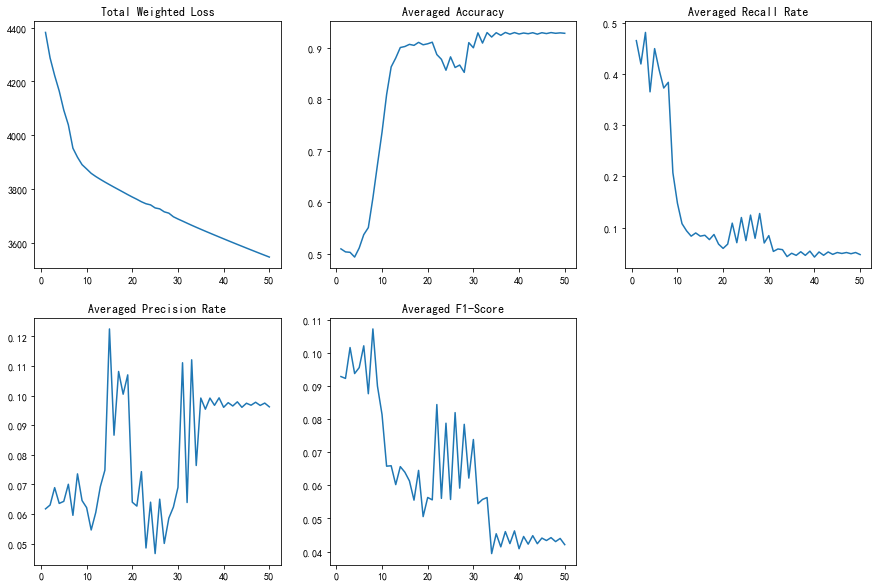

In [39]:
batch_cnt = train_scale //  batch_scale
plot_performance(train_step, cost_arr, acc_arr, rr_arr, pr_arr, f1_arr, batch_cnt=batch_cnt)

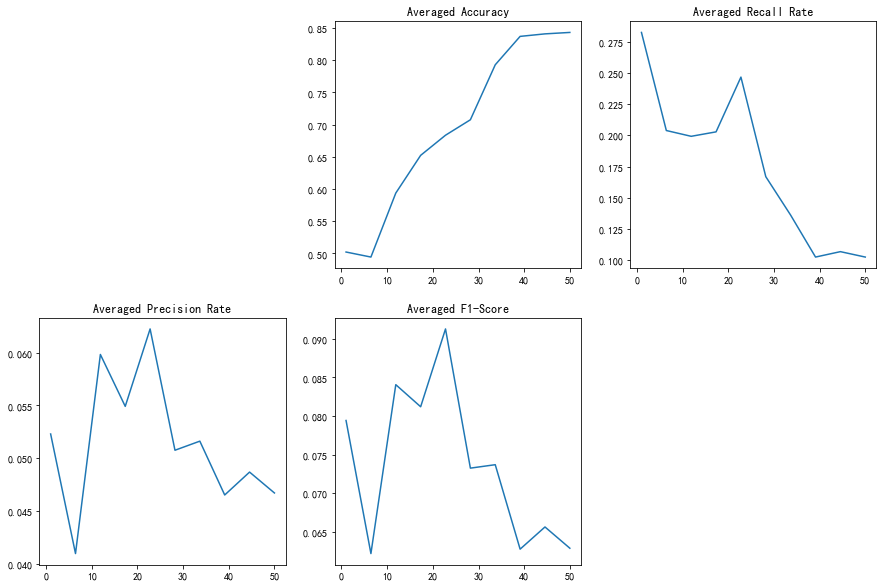

In [40]:
# validation performance
plot_performance(train_step, cost=None, acc=accv, rr=rrv, pr=prv, f1=f1v, step=val_step, batch_cnt=1)

In [41]:
# evaluation model performance in train set
Y_ = model_calc(sess, X_train)
res = evaluation(Y_, Y_train, debug=True)

class, ( tp, fp, tn, fn)
0  :  (60, 65, 2, 1)
1  :  (0, 0, 121, 7)
2  :  (0, 1, 112, 15)
3  :  (0, 1, 117, 10)
4  :  (1, 0, 118, 9)
5  :  (0, 1, 117, 10)
6  :  (0, 0, 125, 3)
7  :  (0, 1, 113, 14)
8  :  (0, 0, 128, 0)
9  :  (0, 0, 128, 0)
10  :  (0, 0, 128, 0)
11  :  (0, 1, 120, 7)
12  :  (0, 0, 127, 1)
13  :  (0, 0, 125, 3)
14  :  (0, 0, 127, 1)
15  :  (0, 1, 127, 0)
16  :  (0, 0, 128, 0)
17  :  (0, 0, 126, 2)
18  :  (0, 1, 121, 6)
19  :  (0, 1, 117, 10)
20  :  (0, 1, 126, 1)
21  :  (1, 0, 115, 12)
22  :  (0, 0, 127, 1)
23  :  (0, 0, 114, 14)
24  :  (0, 0, 126, 2)
25  :  (8, 27, 68, 25)
26  :  (0, 0, 127, 1)
27  :  (0, 0, 128, 0)
class, ( rr, pr, acc, f1)
0  :  (0.98, 0.48, 0.48, 0.65)
1  :  (0.0, 0, 0.95, 0)
2  :  (0.0, 0.0, 0.88, 0)
3  :  (0.0, 0.0, 0.91, 0)
4  :  (0.1, 1.0, 0.93, 0.18)
5  :  (0.0, 0.0, 0.91, 0)
6  :  (0.0, 0, 0.98, 0)
7  :  (0.0, 0.0, 0.88, 0)
8  :  (0, 0, 1.0, 0)
9  :  (0, 0, 1.0, 0)
10  :  (0, 0, 1.0, 0)
11  :  (0.0, 0.0, 0.94, 0)
12  :  (0.0, 0, 0.99, 0)
13  :  

In [42]:
# evaluation model performance in validation set
Y_ = model_calc(sess, X_val)
res = evaluation(Y_, Y_val, debug=True)

class, ( tp, fp, tn, fn)
0  :  (14, 30, 12, 8)
1  :  (0, 19, 44, 1)
2  :  (0, 13, 47, 4)
3  :  (1, 8, 50, 5)
4  :  (2, 8, 50, 4)
5  :  (1, 10, 50, 3)
6  :  (0, 0, 61, 3)
7  :  (1, 9, 50, 4)
8  :  (0, 0, 63, 1)
9  :  (0, 0, 64, 0)
10  :  (0, 0, 64, 0)
11  :  (0, 10, 49, 5)
12  :  (0, 0, 63, 1)
13  :  (0, 0, 63, 1)
14  :  (0, 0, 63, 1)
15  :  (0, 2, 62, 0)
16  :  (0, 0, 62, 2)
17  :  (0, 0, 64, 0)
18  :  (0, 7, 54, 3)
19  :  (1, 13, 45, 5)
20  :  (0, 2, 61, 1)
21  :  (1, 8, 50, 5)
22  :  (0, 0, 62, 2)
23  :  (3, 31, 26, 4)
24  :  (0, 0, 64, 0)
25  :  (10, 36, 9, 9)
26  :  (0, 0, 63, 1)
27  :  (0, 0, 64, 0)
class, ( rr, pr, acc, f1)
0  :  (0.64, 0.32, 0.41, 0.42)
1  :  (0.0, 0.0, 0.69, 0)
2  :  (0.0, 0.0, 0.73, 0)
3  :  (0.17, 0.11, 0.8, 0.13)
4  :  (0.33, 0.2, 0.81, 0.25)
5  :  (0.25, 0.09, 0.8, 0.13)
6  :  (0.0, 0, 0.95, 0)
7  :  (0.2, 0.1, 0.8, 0.13)
8  :  (0.0, 0, 0.98, 0)
9  :  (0, 0, 1.0, 0)
10  :  (0, 0, 1.0, 0)
11  :  (0.0, 0.0, 0.77, 0)
12  :  (0.0, 0, 0.98, 0)
13  :  (0.0, 0, 0.

In [43]:
sess.close()

In [ ]:
#### Boundaries ####

In [163]:
def pickout(P_ob, P_pr):
    P = P_ob * P_pr
    
    print(P_ob.shape, P_pr.shape)
    
    P = P / np.sum(P, axis=1).reshape(-1, 1)
    
    P_ac = np.array([np.sum(P[:,:i+1], axis=1) for i in range(P.shape[1])]).T
    
    res = []
    for item in P:
        idx = np.argmax(item)
        temp = np.zeros(P_ac.shape[1])
        
        temp[idx] = 1
        
        res.append(temp)
    
#     lottery = np.random.uniform(low=0., high=1., size=(P_ac.shape[0],3))
    
#     res = []
#     for lott, P_ac_item in zip(lottery, P_ac):
#         cset = set()
#         for lott_item in lott:
#             for i, p in enumerate(P_ac_item):
#                 if lott_item < p:
#                     cset.add(i)
#                     break
        
#         temp = np.zeros(P_ac.shape[1])
#         for item in cset:
#             temp[item] = 1
        
#         res.append(temp)
    
    return np.array(res)

In [164]:
N = label_mat.shape[0]
P_ob = np.sum(f_mat, axis=0) / N
print([round(item*100, 2) for item in P_ob])

[41.0, 3.9, 11.36, 4.99, 5.98, 8.07, 3.23, 8.96, 0.17, 0.15, 0.09, 3.49, 2.15, 1.65, 3.41, 0.07, 1.56, 0.55, 2.82, 4.75, 0.56, 11.88, 2.55, 9.58, 1.04, 26.08, 1.03, 0.04]


In [165]:
P_pr = np.squeeze(y_)
y_new = pickout(P_ob, P_pr)

(28,) (50, 28)


In [166]:
res = evaluation(y_new, y, debug=True)

class, ( tp, fp, tn, fn)
0  :  (21, 11, 12, 6)
1  :  (0, 0, 48, 2)
2  :  (0, 0, 46, 4)
3  :  (0, 0, 46, 4)
4  :  (0, 0, 49, 1)
5  :  (0, 1, 45, 4)
6  :  (0, 0, 47, 3)
7  :  (0, 0, 47, 3)
8  :  (0, 0, 50, 0)
9  :  (0, 0, 50, 0)
10  :  (0, 0, 50, 0)
11  :  (0, 0, 50, 0)
12  :  (0, 0, 48, 2)
13  :  (0, 0, 49, 1)
14  :  (0, 0, 50, 0)
15  :  (0, 0, 50, 0)
16  :  (0, 0, 50, 0)
17  :  (0, 0, 48, 2)
18  :  (0, 0, 49, 1)
19  :  (0, 0, 47, 3)
20  :  (0, 0, 50, 0)
21  :  (0, 0, 44, 6)
22  :  (0, 0, 49, 1)
23  :  (2, 1, 46, 1)
24  :  (0, 0, 49, 1)
25  :  (8, 6, 27, 9)
26  :  (0, 0, 49, 1)
27  :  (0, 0, 50, 0)
class, ( rr, pr, acc, f1)
0  :  (0.78, 0.66, 0.66, 0.71)
1  :  (0.0, 0, 0.96, 0)
2  :  (0.0, 0, 0.92, 0)
3  :  (0.0, 0, 0.92, 0)
4  :  (0.0, 0, 0.98, 0)
5  :  (0.0, 0.0, 0.9, 0)
6  :  (0.0, 0, 0.94, 0)
7  :  (0.0, 0, 0.94, 0)
8  :  (0, 0, 1.0, 0)
9  :  (0, 0, 1.0, 0)
10  :  (0, 0, 1.0, 0)
11  :  (0, 0, 1.0, 0)
12  :  (0.0, 0, 0.96, 0)
13  :  (0.0, 0, 0.98, 0)
14  :  (0, 0, 1.0, 0)
15  :  (0, 